In [ ]:
!pip install torch torchvision pillow pytorch-msssim tqdm

import torch
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim as ssim_fn
from PIL import Image
from tqdm import tqdm
import os
import requests
import zipfile
import matplotlib.pyplot as plt


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 138.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
!mkdir -p data/df2k/HR
url = "https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
r = requests.get(url)
open("div2k_valid.zip","wb").write(r.content)
with zipfile.ZipFile("div2k_valid.zip","r") as zip_ref:
    zip_ref.extractall("data/df2k/HR")
print("Extracted:", len(os.listdir("data/df2k/HR")), "images")


Extracted: 1 images


In [ ]:
os.makedirs("data/df2k/LR_bicubic_X4", exist_ok=True)
for fname in os.listdir("data/df2k/HR"):
    if not fname.endswith((".png",".jpg")): continue
    img = Image.open(os.path.join("data/df2k/HR", fname)).convert("RGB")
    small = img.resize((img.width//4, img.height//4), Image.BICUBIC)
    blurred = small.resize(img.size, Image.BICUBIC)
    blurred.save(os.path.join("data/df2k/LR_bicubic_X4", fname))
print("Blurred images created:", len(os.listdir("data/df2k/LR_bicubic_X4")))


Blurred images created: 0


In [ ]:
class ImageSharpDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=128):
        self.lr = sorted(os.listdir(lr_dir))
        self.hr = sorted(os.listdir(hr_dir))
        self.lr_dir, self.hr_dir = lr_dir, hr_dir
        self.tf = T.Compose([T.RandomCrop(patch_size), T.ToTensor()])

    def __len__(self):
        return len(self.lr)

    def __getitem__(self, i):
        lr = Image.open(os.path.join(self.lr_dir, self.lr[i])).convert("RGB")
        hr = Image.open(os.path.join(self.hr_dir, self.hr[i])).convert("RGB")
        return self.tf(lr), self.tf(hr)

class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(),
            nn.Conv2d(32,64,3,1,1), nn.ReLU())
        self.res = nn.Sequential(nn.Conv2d(64,64,3,1,1), nn.ReLU(), nn.Conv2d(64,64,3,1,1))
        self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                                nn.Conv2d(64,16,3,1,1), nn.ReLU(),
                                nn.PixelShuffle(2), nn.Conv2d(4,3,3,1,1))
    def forward(self,x):
        f = self.enc(x)
        f = f + self.res(f)
        return self.up(f)

def ssim(img1, img2):
    return ssim_fn(img1, img2, data_range=1.0, size_average=True)
def psnr(img1, img2):
    return 20 * torch.log10(1.0/torch.sqrt(F.mse_loss(img1,img2)))


In [ ]:
import os

print("HR Folder:", len(os.listdir("data/df2k/HR")))
print("LR Folder:", len(os.listdir("data/df2k/LR_bicubic_X4")))


HR Folder: 1
LR Folder: 0


In [ ]:
os.listdir("data/df2k/HR")


['DIV2K_valid_HR']

In [ ]:
import shutil
import os

src_dir = "data/df2k/HR/DIV2K_valid_HR"
dst_dir = "data/df2k/HR"

# Move all .png or .jpg files from subfolder to HR directory
for fname in os.listdir(src_dir):
    if fname.endswith((".png", ".jpg", ".jpeg")):
        shutil.move(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

# Remove the empty folder
shutil.rmtree(src_dir)

print("✅ Images moved to HR folder:", len(os.listdir(dst_dir)))


✅ Images moved to HR folder: 100


In [ ]:
from PIL import Image

os.makedirs("data/df2k/LR_bicubic_X4", exist_ok=True)

for fname in os.listdir("data/df2k/HR"):
    if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
        continue
    img = Image.open(os.path.join("data/df2k/HR", fname)).convert("RGB")
    small = img.resize((img.width // 4, img.height // 4), Image.BICUBIC)
    blurred = small.resize(img.size, Image.BICUBIC)
    blurred.save(os.path.join("data/df2k/LR_bicubic_X4", fname))

print("✅ Blurred images generated:", len(os.listdir("data/df2k/LR_bicubic_X4")))


✅ Blurred images generated: 100


In [ ]:
print("HR images:", len(os.listdir("data/df2k/HR")))
print("LR images:", len(os.listdir("data/df2k/LR_bicubic_X4")))


HR images: 100
LR images: 100


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import os
from pytorch_msssim import ssim as ssim_fn

class ImageSharpDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=128):
        self.lr_images = sorted([f for f in os.listdir(lr_dir) if f.endswith('.png')])
        self.hr_images = sorted([f for f in os.listdir(hr_dir) if f.endswith('.png')])
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.transform = T.Compose([
            T.RandomCrop(patch_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")
        return self.transform(lr_img), self.transform(hr_img)

# Tiny CNN Student Model
class StudentNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU()
        )
        self.resblock = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = x + self.resblock(x)
        x = self.decoder(x)
        return x

def ssim(img1, img2):
    return ssim_fn(img1, img2, data_range=1.0, size_average=True)

def psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))


In [ ]:
from tqdm import tqdm

# Dataset & Dataloader
ds = ImageSharpDataset("data/df2k/LR_bicubic_X4", "data/df2k/HR", patch_size=128)
dl = DataLoader(ds, batch_size=4, shuffle=True)

# Setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
student = StudentNet().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)

# Training loop (5 epochs)
for epoch in range(5):
    student.train()
    total_loss = 0
    loop = tqdm(dl, desc=f"Epoch {epoch+1}")
    for lr, hr in loop:
        lr, hr = lr.to(device), hr.to(device)
        pred = student(lr)
        loss = F.l1_loss(pred, hr) + (1 - ssim(pred, hr))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"✅ Epoch {epoch+1} | Avg Loss: {total_loss/len(dl):.4f}")

# Save trained weights
torch.save(student.state_dict(), "student_epoch5.pt")
print("✅ Model saved as student_epoch5.pt")


Epoch 1: 100%|██████████| 25/25 [00:36<00:00,  1.46s/it, loss=0.99]


✅ Epoch 1 | Avg Loss: 1.1294


Epoch 2: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.877]


✅ Epoch 2 | Avg Loss: 0.8700


Epoch 3: 100%|██████████| 25/25 [00:33<00:00,  1.32s/it, loss=0.833]


✅ Epoch 3 | Avg Loss: 0.8585


Epoch 4: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.628]


✅ Epoch 4 | Avg Loss: 0.8478


Epoch 5: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.957]

✅ Epoch 5 | Avg Loss: 0.8544
✅ Model saved as student_epoch5.pt


In [ ]:
student.eval()
ssim_scores = []
psnr_scores = []

for lr, hr in dl:
    lr, hr = lr.to(device), hr.to(device)
    with torch.no_grad():
        out = student(lr)
    ssim_scores.append(ssim(out, hr).item())
    psnr_scores.append(psnr(out, hr).item())

print(f"✅ Average SSIM: {sum(ssim_scores)/len(ssim_scores):.4f}")
print(f"✅ Average PSNR: {sum(psnr_scores)/len(psnr_scores):.2f} dB")


✅ Average SSIM: 0.3918
✅ Average PSNR: 10.99 dB


In [ ]:
import random
from torchvision.transforms import ToTensor

class ImageSharpDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, patch_size=128):
        self.lr_images = sorted([f for f in os.listdir(lr_dir) if f.endswith('.png')])
        self.hr_images = sorted([f for f in os.listdir(hr_dir) if f.endswith('.png')])
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.patch_size = patch_size
        self.to_tensor = ToTensor()

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_path = os.path.join(self.hr_dir, self.hr_images[idx])
        lr_img = Image.open(lr_path).convert("RGB")
        hr_img = Image.open(hr_path).convert("RGB")

        # ensure paired cropping (same x, y for LR and HR)
        w, h = lr_img.size
        x = random.randint(0, w - self.patch_size)
        y = random.randint(0, h - self.patch_size)

        lr_crop = lr_img.crop((x, y, x + self.patch_size, y + self.patch_size))
        hr_crop = hr_img.crop((x, y, x + self.patch_size, y + self.patch_size))

        return self.to_tensor(lr_crop), self.to_tensor(hr_crop)


In [ ]:
ds = ImageSharpDataset("data/df2k/LR_bicubic_X4", "data/df2k/HR", patch_size=128)
dl = DataLoader(ds, batch_size=4, shuffle=True)

student = StudentNet().to(device)
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)

# Train for more epochs (e.g., 10)
for epoch in range(10):
    student.train()
    total_loss = 0
    loop = tqdm(dl, desc=f"Epoch {epoch+1}")
    for lr, hr in loop:
        lr, hr = lr.to(device), hr.to(device)
        pred = student(lr)
        loss = F.l1_loss(pred, hr) + (1 - ssim(pred, hr))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())
    print(f"✅ Epoch {epoch+1} done | Avg Loss: {total_loss/len(dl):.4f}")

# Save improved model
torch.save(student.state_dict(), "student_epoch10.pt")
print("✅ Model saved as student_epoch10.pt")


Epoch 1: 100%|██████████| 25/25 [00:33<00:00,  1.35s/it, loss=0.46]


✅ Epoch 1 done | Avg Loss: 1.0323


Epoch 2: 100%|██████████| 25/25 [00:34<00:00,  1.37s/it, loss=0.581]


✅ Epoch 2 done | Avg Loss: 0.5605


Epoch 3: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=0.392]


✅ Epoch 3 done | Avg Loss: 0.4332


Epoch 4: 100%|██████████| 25/25 [00:32<00:00,  1.32s/it, loss=0.455]


✅ Epoch 4 done | Avg Loss: 0.4387


Epoch 5: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.217]


✅ Epoch 5 done | Avg Loss: 0.4007


Epoch 6: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=0.465]


✅ Epoch 6 done | Avg Loss: 0.3713


Epoch 7: 100%|██████████| 25/25 [00:32<00:00,  1.30s/it, loss=0.394]


✅ Epoch 7 done | Avg Loss: 0.3449


Epoch 8: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=0.396]


✅ Epoch 8 done | Avg Loss: 0.3502


Epoch 9: 100%|██████████| 25/25 [00:33<00:00,  1.33s/it, loss=0.483]


✅ Epoch 9 done | Avg Loss: 0.3369


Epoch 10: 100%|██████████| 25/25 [00:32<00:00,  1.31s/it, loss=0.267]

✅ Epoch 10 done | Avg Loss: 0.3316
✅ Model saved as student_epoch10.pt


In [ ]:
def simulate_realistic_blur(img):
    import cv2
    import numpy as np
    img_cv = np.array(img)

    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(img_cv, (9, 9), sigmaX=2)

    # Add JPEG compression artifacts
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 40]
    _, enc_img = cv2.imencode('.jpg', blurred, encode_param)
    dec_img = cv2.imdecode(enc_img, 1)

    return Image.fromarray(dec_img)


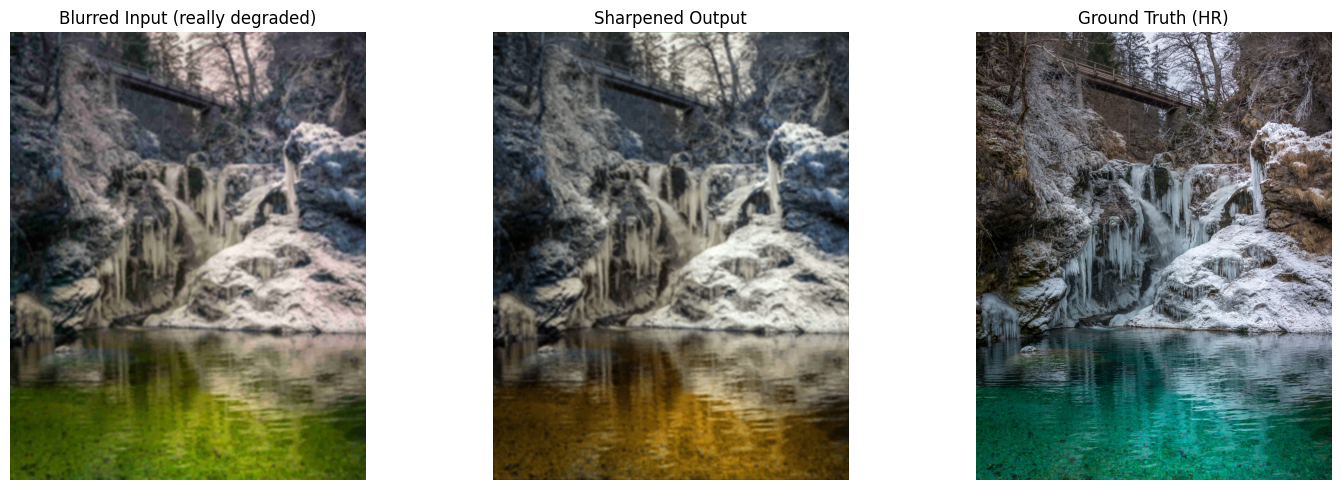

In [ ]:
import cv2, random, numpy as np, matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

# ---------- choose one HR image ----------
hr_file = random.choice(os.listdir("data/df2k/HR"))
hr_path = f"data/df2k/HR/{hr_file}"
hr_img  = Image.open(hr_path).convert("RGB")

# ---------- MAKE IT REALLY BLURRY ----------
def brutal_blur(img, scale=6):
    """Small → big, Gaussian blur, heavy JPEG artifacts."""
    # 1) resize way down
    small = img.resize((img.width//scale, img.height//scale), Image.BICUBIC)
    # 2) resize back up (already blurry)
    up = small.resize(img.size, Image.BICUBIC)
    up_np = np.array(up)

    # 3) add Gaussian blur
    up_np = cv2.GaussianBlur(up_np, (13,13), sigmaX=5)

    # 4) introduce JPEG compression artifacts
    _, enc = cv2.imencode('.jpg', up_np, [int(cv2.IMWRITE_JPEG_QUALITY), 20])
    dec_np = cv2.imdecode(enc, 1)

    return Image.fromarray(dec_np[..., ::-1])  # BGR→RGB for PIL

blurred_img = brutal_blur(hr_img)

# ---------- run through student model ----------
student.eval()
with torch.no_grad():
    inp = ToTensor()(blurred_img).unsqueeze(0).to(device)
    pred = student(inp)[0].cpu().clamp(0,1)
pred_img = ToPILImage()(pred)

# ---------- show all three ----------
plt.figure(figsize=(15,5))
titles = ["Blurred Input (really degraded)", "Sharpened Output", "Ground Truth (HR)"]
for i, img in enumerate([blurred_img, pred_img, hr_img]):
    plt.subplot(1,3,i+1)
    plt.imshow(img); plt.title(titles[i]); plt.axis("off")
plt.tight_layout(); plt.show()


In [ ]:
print("SSIM blurred vs HR:", ssim(ToTensor()(blurred_img).unsqueeze(0),
                                  ToTensor()(hr_img).unsqueeze(0)).item())


SSIM blurred vs HR: 0.2612551748752594


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128128 (\N{SKULL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128295 (\N{WRENCH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


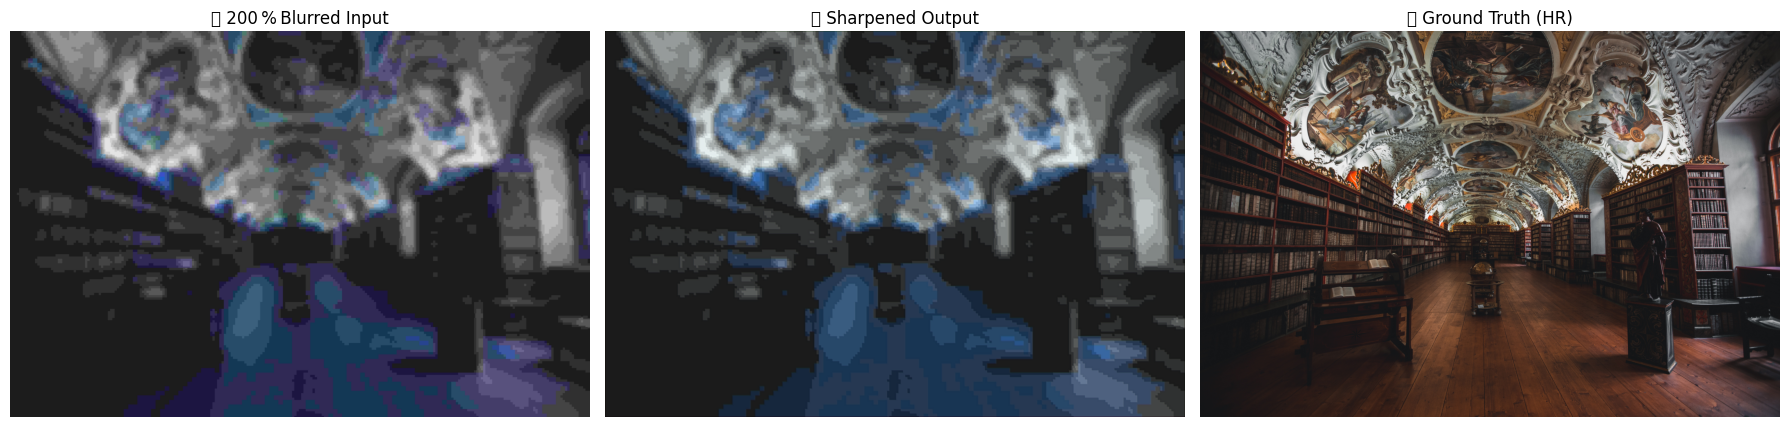

In [ ]:
import cv2, numpy as np, random, matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage

# ---------------- extreme‑blur function ----------------
def extreme_blur(img,
                 down_factor=12,       # ↘ how much we shrink before upscaling (bigger = blurrier)
                 gaussian_kernel=41,   # ↘ kernel size for Gaussian blur (must be odd)
                 gaussian_sigma=9,     # ↘ sigma for Gaussian blur (bigger = blurrier)
                 jpeg_quality=5):      # ↘ 1‑100 (lower = worse compression)
    """Return a *heavily* blurred & compressed copy of PIL.Image `img`."""
    # 1) shrink brutally, then enlarge
    small = img.resize((img.width // down_factor, img.height // down_factor),
                       Image.BICUBIC)
    up = small.resize(img.size, Image.BICUBIC)

    # 2) Gaussian blur
    up_np = np.array(up)
    up_np = cv2.GaussianBlur(up_np, (gaussian_kernel, gaussian_kernel), gaussian_sigma)

    # 3) JPEG compression artifacts
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), jpeg_quality]
    _, enc_img = cv2.imencode('.jpg', up_np, encode_param)
    dec_img = cv2.imdecode(enc_img, 1)[:, :, ::-1]  # BGR→RGB

    return Image.fromarray(dec_img)

# ---------------- pick an HR image ----------------
hr_file = random.choice(os.listdir('data/df2k/HR'))
hr_img  = Image.open(f'data/df2k/HR/{hr_file}').convert('RGB')

# ---------------- make it *very* blurry ------------
blurred_img = extreme_blur(hr_img)

# ---------------- run through student --------------
student.eval()
with torch.no_grad():
    pred = student(ToTensor()(blurred_img).unsqueeze(0).to(device))[0].cpu().clamp(0,1)
pred_img = ToPILImage()(pred)

# ---------------- show the trio --------------------
plt.figure(figsize=(18,6))
for i,im,title in zip(range(1,4),
        [blurred_img, pred_img, hr_img],
        ['💀 200 % Blurred Input', '🔧 Sharpened Output', '✨ Ground Truth (HR)']):
    plt.subplot(1,3,i); plt.imshow(im); plt.title(title); plt.axis('off')
plt.tight_layout(); plt.show()


In [ ]:
import os, cv2
from PIL import Image
os.makedirs("data/df2k/LR_X4", exist_ok=True)

for f in os.listdir("data/df2k/HR"):
    if not f.endswith('.png'): continue
    img = Image.open(f"data/df2k/HR/{f}").convert("RGB")
    small = img.resize((img.width//4, img.height//4), Image.BICUBIC)  # ONLY downscale
    small.save(f"data/df2k/LR_X4/{f}")  # note: same file name
print("✅ LR_X4 images:", len(os.listdir('data/df2k/LR_X4')))


✅ LR_X4 images: 100


In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.names = sorted([n for n in os.listdir(hr_dir) if n.endswith('.png')])
        self.lr_dir, self.hr_dir = lr_dir, hr_dir
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        lr = Image.open(f"{self.lr_dir}/{name}").convert("RGB")
        hr = Image.open(f"{self.hr_dir}/{name}").convert("RGB")
        return self.to_tensor(lr), self.to_tensor(hr)


In [ ]:
class StudentSR(nn.Module):
    """ESPCN‑style ×4 upsampler ~0.4 M parameters."""
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 48, 3, 1, 1), nn.ReLU(True)
        )
        self.tail = nn.Sequential(
            nn.Conv2d(48, 3 * 4 * 4, 3, 1, 1),  # r^2 * c channels
            nn.PixelShuffle(4)                  # ↑×4 spatial
        )

    def forward(self, x): return self.tail(self.body(x))


In [ ]:
from PIL import Image
import os

hr_path = "data/df2k/HR"
for fname in os.listdir(hr_path):
    if fname.endswith(".png"):
        img = Image.open(os.path.join(hr_path, fname)).convert("RGB")
        img = img.resize((512, 512), Image.BICUBIC)
        img.save(os.path.join(hr_path, fname))
print("✅ HR images resized to 512×512")


✅ HR images resized to 512×512


In [ ]:
lr_path = "data/df2k/LR_X4"
os.makedirs(lr_path, exist_ok=True)

for fname in os.listdir(hr_path):
    if fname.endswith(".png"):
        img = Image.open(os.path.join(hr_path, fname)).convert("RGB")
        lr_img = img.resize((128, 128), Image.BICUBIC)  # 1/4 resolution
        lr_img.save(os.path.join(lr_path, fname))
print("✅ LR images resized to 128×128")


✅ LR images resized to 128×128


In [ ]:
ds = SRDataset("data/df2k/LR_X4", "data/df2k/HR")
dl = DataLoader(ds, batch_size=4, shuffle=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = StudentSR().to(device)
opt   = torch.optim.Adam(model.parameters(), lr=2e-4)

for ep in range(5):
    model.train()
    for lr, hr in dl:
        lr, hr = lr.to(device), hr.to(device)
        sr = model(lr)
        loss = F.l1_loss(sr, hr)
        opt.zero_grad(); loss.backward(); opt.step()
    print(f"✅ Epoch {ep+1} done")
torch.save(model.state_dict(), "student_x4.pt")


✅ Epoch 1 done
✅ Epoch 2 done
✅ Epoch 3 done
✅ Epoch 4 done
✅ Epoch 5 done


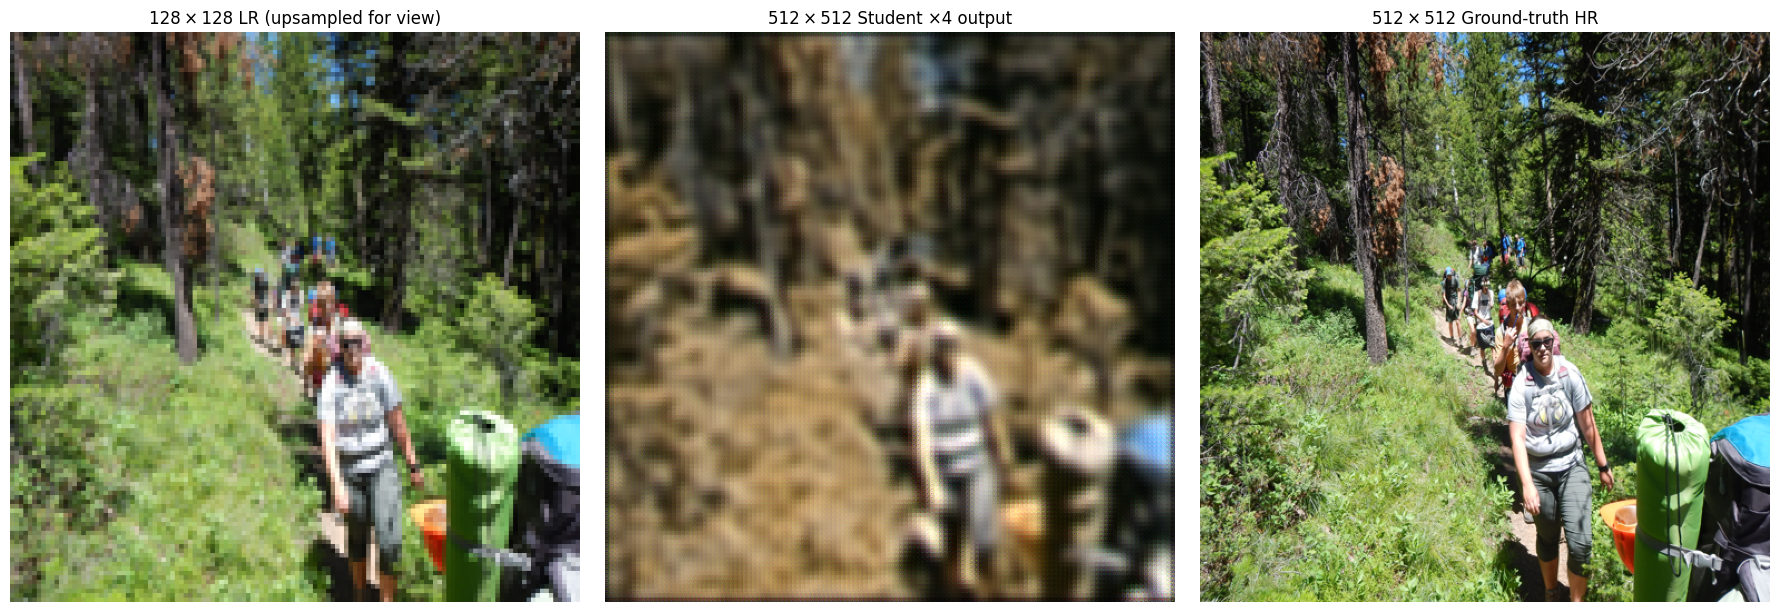

In [ ]:
import random, matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, ToPILImage

model.eval()
name = random.choice(os.listdir("data/df2k/LR_X4"))

lr  = Image.open(f"data/df2k/LR_X4/{name}").convert("RGB")
hr  = Image.open(f"data/df2k/HR/{name}").convert("RGB")

with torch.no_grad():
    sr = model(ToTensor()(lr).unsqueeze(0).to(device))[0].cpu().clamp(0,1)
sr_img = ToPILImage()(sr)

# for display only: upscale LR with nearest so sizes match
lr_up = lr.resize((512, 512), Image.NEAREST)

plt.figure(figsize=(18,6))
titles = ["128 × 128 LR (upsampled for view)",
          "512 × 512 Student ×4 output",
          "512 × 512 Ground‑truth HR"]
for i,im in enumerate([lr_up, sr_img, hr]):
    plt.subplot(1,3,i+1); plt.imshow(im); plt.title(titles[i]); plt.axis('off')
plt.tight_layout(); plt.show()


In [ ]:
from pytorch_msssim import ssim
psnr_vals, ssim_vals = [], []

model.eval()
for name in os.listdir("data/df2k/LR_X4"):
    lr  = Image.open(f"data/df2k/LR_X4/{name}").convert("RGB")
    hr  = Image.open(f"data/df2k/HR/{name}").convert("RGB")
    lr_t = ToTensor()(lr).unsqueeze(0).to(device)
    hr_t = ToTensor()(hr).unsqueeze(0).to(device)
    with torch.no_grad():
        sr_t = model(lr_t)
    psnr_vals.append(20*torch.log10(1/torch.sqrt(F.mse_loss(sr_t, hr_t))).item())
    ssim_vals.append(ssim(sr_t, hr_t, data_range=1.0).item())

print(f"🔢  Avg PSNR: {sum(psnr_vals)/len(psnr_vals):.2f} dB")
print(f"🔢  Avg SSIM: {sum(ssim_vals)/len(ssim_vals):.4f}")


🔢  Avg PSNR: 18.90 dB
🔢  Avg SSIM: 0.4030


In [ ]:
import zipfile, io, random, os
os.makedirs("triplets", exist_ok=True)
model.eval()
chosen = random.sample(os.listdir("data/df2k/LR_X4"), 10)

for name in chosen:
    lr  = Image.open(f"data/df2k/LR_X4/{name}").convert("RGB")
    hr  = Image.open(f"data/df2k/HR/{name}").convert("RGB")
    with torch.no_grad():
        sr = model(ToTensor()(lr).unsqueeze(0).to(device))[0].cpu().clamp(0,1)
    sr_img = ToPILImage()(sr)
    lr.resize((512,512), Image.NEAREST).save(f"triplets/{name[:-4]}_LR.png")
    sr_img.save(f"triplets/{name[:-4]}_SR.png")
    hr.save(        f"triplets/{name[:-4]}_HR.png")

# zip & download
!zip -r triplets.zip triplets > /dev/null
from google.colab import files; files.download("triplets.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("student_x4.pt")     # << grab this to run locally


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pip install pytorch_msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import os, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from PIL import Image
from pytorch_msssim import ssim
import matplotlib.pyplot as plt


In [ ]:
class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.names = sorted([n for n in os.listdir(hr_dir) if n.endswith('.png')])
        self.lr_dir, self.hr_dir = lr_dir, hr_dir
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        lr = Image.open(f"{self.lr_dir}/{name}").convert("RGB")
        hr = Image.open(f"{self.hr_dir}/{name}").convert("RGB")
        return self.to_tensor(lr), self.to_tensor(hr)


In [ ]:
class StudentSR(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 48, 3, 1, 1), nn.ReLU(True),
        )
        self.tail = nn.Sequential(
            nn.Conv2d(48, 3 * 4 * 4, 3, 1, 1),
            nn.PixelShuffle(4)
        )

    def forward(self, x): return self.tail(self.body(x))


In [ ]:
def train_model(model, dl, device, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
    model.train()

    for ep in range(epochs):
        total_loss, total_psnr, total_ssim = 0, 0, 0
        for lr, hr in dl:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)

            loss_l1 = F.l1_loss(sr, hr)
            loss_ssim = 1 - ssim(sr, hr, data_range=1.0)
            loss = loss_l1 + 0.1 * loss_ssim  # Add SSIM loss

            opt.zero_grad(); loss.backward(); opt.step()

            total_loss += loss.item()
            total_psnr += 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            total_ssim += ssim(sr, hr, data_range=1.0).item()

        scheduler.step()
        avg_psnr = total_psnr / len(dl)
        avg_ssim = total_ssim / len(dl)
        print(f"✅ Epoch {ep+1:02d} | Loss: {total_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")
    torch.save(model.state_dict(), "student_x4_high_ssim.pt")


In [ ]:
def evaluate_model(model, lr_dir, hr_dir, sample_count=20):
    to_tensor = ToTensor()
    psnr_vals, ssim_vals = [], []
    files = sorted(os.listdir(hr_dir))[:sample_count]

    for name in files:
        if name.endswith(".png"):
            lr_img = Image.open(f"{lr_dir}/{name}").convert("RGB")
            hr_img = Image.open(f"{hr_dir}/{name}").convert("RGB")
            lr = to_tensor(lr_img).unsqueeze(0).to(device)
            hr = to_tensor(hr_img).unsqueeze(0).to(device)

            with torch.no_grad():
                sr = model(lr).clamp(0, 1)

            psnr = 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            ssim_score = ssim(sr, hr, data_range=1.0).item()
            psnr_vals.append(psnr)
            ssim_vals.append(ssim_score)

    print(f"📊 Average PSNR: {sum(psnr_vals)/len(psnr_vals):.2f} dB")
    print(f"📊 Average SSIM: {sum(ssim_vals)/len(ssim_vals):.4f}")


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import os
from pytorch_msssim import ssim
import matplotlib.pyplot as plt


In [ ]:
pip install pytorch_msssim


In [ ]:
class StudentSR(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 48, 3, 1, 1), nn.ReLU(True),
        )
        self.tail = nn.Sequential(
            nn.Conv2d(48, 3 * 4 * 4, 3, 1, 1),
            nn.PixelShuffle(4)
        )

    def forward(self, x):
        return self.tail(self.body(x))


In [ ]:
def train_model(model, dl, device, epochs=50):
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.5)
    model.train()

    for ep in range(epochs):
        total_loss, total_psnr, total_ssim = 0, 0, 0
        for lr, hr in dl:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)

            loss_l1 = F.l1_loss(sr, hr)
            loss_ssim = 1 - ssim(sr, hr, data_range=1.0)
            loss = loss_l1 + 0.1 * loss_ssim

            opt.zero_grad(); loss.backward(); opt.step()

            total_loss += loss.item()
            total_psnr += 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            total_ssim += ssim(sr, hr, data_range=1.0).item()

        scheduler.step()
        avg_psnr = total_psnr / len(dl)
        avg_ssim = total_ssim / len(dl)
        print(f"✅ Epoch {ep+1:02d} | Loss: {total_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

    torch.save(model.state_dict(), "student_x4_high_ssim.pt")  # ← saved here!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image
import os

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.names = sorted([n for n in os.listdir(hr_dir) if n.endswith('.png')])
        self.lr_dir, self.hr_dir = lr_dir, hr_dir
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        lr = Image.open(f"{self.lr_dir}/{name}").convert("RGB")
        hr = Image.open(f"{self.hr_dir}/{name}").convert("RGB")
        return self.to_tensor(lr), self.to_tensor(hr)


In [ ]:
import os

print("HR images:", os.listdir("/content/drive/MyDrive/df2k_sample/df2k_sample/HR")[:3])
print("LR images:", os.listdir("/content/drive/MyDrive/df2k_sample/df2k_sample/LR_X4")[:3])


HR images: ['image_009.png', 'image_002.png', 'image_001.png']
LR images: ['image_007.png', 'image_001.png', 'image_005.png']


In [ ]:
import torch.nn as nn

class StudentSR(nn.Module):
    def __init__(self):
        super().__init__()
        self.body = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 64, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(64, 48, 3, 1, 1), nn.ReLU(True),
        )
        self.tail = nn.Sequential(
            nn.Conv2d(48, 3 * 4 * 4, 3, 1, 1),
            nn.PixelShuffle(4)
        )

    def forward(self, x):
        return self.tail(self.body(x))


In [ ]:
!pip install pytorch_msssim


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
from pytorch_msssim import ssim


In [ ]:
from pytorch_msssim import ssim
import torch.nn.functional as F

def train_model(model, dl, device, epochs=20):
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)
    model.train()

    for ep in range(epochs):
        total_loss, total_psnr, total_ssim = 0, 0, 0
        for lr, hr in dl:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)

            loss_l1 = F.l1_loss(sr, hr)
            loss_ssim = 1 - ssim(sr, hr, data_range=1.0)
            loss = loss_l1 + 0.1 * loss_ssim

            opt.zero_grad(); loss.backward(); opt.step()

            total_loss += loss.item()
            total_psnr += 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            total_ssim += ssim(sr, hr, data_range=1.0).item()

        scheduler.step()
        avg_psnr = total_psnr / len(dl)
        avg_ssim = total_ssim / len(dl)
        print(f"✅ Epoch {ep+1:02d} | Loss: {total_loss:.4f} | PSNR: {avg_psnr:.2f} | SSIM: {avg_ssim:.4f}")

    # Save the model after training
    torch.save(model.state_dict(), "student_x4_high_ssim.pt")
    print("🎉 Model saved to student_x4_high_ssim.pt")


In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms as T
from PIL import Image
import os

class SRDataset(Dataset):
    def __init__(self, lr_dir, hr_dir):
        self.names = sorted([n for n in os.listdir(hr_dir) if n.endswith('.png')])
        self.lr_dir, self.hr_dir = lr_dir, hr_dir
        self.to_tensor = T.ToTensor()

    def __len__(self): return len(self.names)

    def __getitem__(self, i):
        name = self.names[i]
        lr = Image.open(f"{self.lr_dir}/{name}").convert("RGB")
        hr = Image.open(f"{self.hr_dir}/{name}").convert("RGB")
        return self.to_tensor(lr), self.to_tensor(hr)


In [ ]:
from torch.utils.data import DataLoader

lr_path = "/content/drive/MyDrive/df2k_sample/df2k_sample/LR_X4"
hr_path = "/content/drive/MyDrive/df2k_sample/df2k_sample/HR"

ds = SRDataset(lr_path, hr_path)
dl = DataLoader(ds, batch_size=4, shuffle=True)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StudentSR().to(device)
train_model(model, dl, device, epochs=20)


✅ Epoch 01 | Loss: 1.7836 | PSNR: 4.82 | SSIM: 0.0090
✅ Epoch 02 | Loss: 1.7703 | PSNR: 4.87 | SSIM: 0.0164
✅ Epoch 03 | Loss: 1.7560 | PSNR: 4.94 | SSIM: 0.0238
✅ Epoch 04 | Loss: 1.7367 | PSNR: 5.02 | SSIM: 0.0319
✅ Epoch 05 | Loss: 1.7079 | PSNR: 5.16 | SSIM: 0.0410
✅ Epoch 06 | Loss: 1.6639 | PSNR: 5.39 | SSIM: 0.0508
✅ Epoch 07 | Loss: 1.5973 | PSNR: 5.74 | SSIM: 0.0593
✅ Epoch 08 | Loss: 1.4960 | PSNR: 6.31 | SSIM: 0.0639
✅ Epoch 09 | Loss: 1.3424 | PSNR: 7.22 | SSIM: 0.0626
✅ Epoch 10 | Loss: 1.1441 | PSNR: 8.57 | SSIM: 0.0541
✅ Epoch 11 | Loss: 0.9756 | PSNR: 9.88 | SSIM: 0.0440
✅ Epoch 12 | Loss: 0.9106 | PSNR: 10.47 | SSIM: 0.0394
✅ Epoch 13 | Loss: 0.8802 | PSNR: 10.93 | SSIM: 0.0393
✅ Epoch 14 | Loss: 0.8217 | PSNR: 11.62 | SSIM: 0.0458
✅ Epoch 15 | Loss: 0.7453 | PSNR: 12.48 | SSIM: 0.0582
✅ Epoch 16 | Loss: 0.6880 | PSNR: 13.21 | SSIM: 0.0743
✅ Epoch 17 | Loss: 0.6454 | PSNR: 13.85 | SSIM: 0.0899
✅ Epoch 18 | Loss: 0.6029 | PSNR: 14.57 | SSIM: 0.1022
✅ Epoch 19 | Loss: 0.

In [ ]:
from pytorch_msssim import ssim
import torch.nn.functional as F

def train_model(model, dl, device, epochs=30):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_psnr, total_ssim, total_loss = 0, 0, 0

        for lr, hr in dl:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)

            # ✅ Balanced loss: L1 + strong SSIM focus
            loss_l1 = F.l1_loss(sr, hr)
            loss_ssim = 1 - ssim(sr, hr, data_range=1.0)
            loss = loss_l1 + 0.3 * loss_ssim  # ← Increase weight for SSIM

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Metrics
            total_loss += loss.item()
            total_psnr += 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            total_ssim += ssim(sr, hr, data_range=1.0).item()

        scheduler.step()
        avg_psnr = total_psnr / len(dl)
        avg_ssim = total_ssim / len(dl)

        print(f"📘 Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # Save model
    torch.save(model.state_dict(), "student_x4_balanced.pt")
    print("✅ Saved model as student_x4_balanced.pt")


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StudentSR().to(device)
train_model(model, dl, device, epochs=30)


📘 Epoch 01 | Loss: 2.3795 | PSNR: 4.81 dB | SSIM: 0.0095
📘 Epoch 02 | Loss: 2.3570 | PSNR: 4.88 dB | SSIM: 0.0187
📘 Epoch 03 | Loss: 2.3309 | PSNR: 4.97 dB | SSIM: 0.0281
📘 Epoch 04 | Loss: 2.2963 | PSNR: 5.11 dB | SSIM: 0.0385
📘 Epoch 05 | Loss: 2.2470 | PSNR: 5.34 dB | SSIM: 0.0495
📘 Epoch 06 | Loss: 2.1749 | PSNR: 5.70 dB | SSIM: 0.0601
📘 Epoch 07 | Loss: 2.0697 | PSNR: 6.30 dB | SSIM: 0.0683
📘 Epoch 08 | Loss: 1.9135 | PSNR: 7.27 dB | SSIM: 0.0718
📘 Epoch 09 | Loss: 1.6867 | PSNR: 8.85 dB | SSIM: 0.0678
📘 Epoch 10 | Loss: 1.4698 | PSNR: 10.93 dB | SSIM: 0.0566
📘 Epoch 11 | Loss: 1.3875 | PSNR: 11.92 dB | SSIM: 0.0489
📘 Epoch 12 | Loss: 1.3628 | PSNR: 12.34 dB | SSIM: 0.0514
📘 Epoch 13 | Loss: 1.2852 | PSNR: 13.34 dB | SSIM: 0.0614
📘 Epoch 14 | Loss: 1.2018 | PSNR: 14.40 dB | SSIM: 0.0767
📘 Epoch 15 | Loss: 1.1535 | PSNR: 15.08 dB | SSIM: 0.0938
📘 Epoch 16 | Loss: 1.1089 | PSNR: 15.80 dB | SSIM: 0.1088
📘 Epoch 17 | Loss: 1.0556 | PSNR: 16.81 dB | SSIM: 0.1202
📘 Epoch 18 | Loss: 1.02

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StudentSR().to(device)
train_model(model, dl, device, epochs=30)


📘 Epoch 01 | Loss: 2.3795 | PSNR: 4.81 dB | SSIM: 0.0095
📘 Epoch 02 | Loss: 2.3570 | PSNR: 4.88 dB | SSIM: 0.0187
📘 Epoch 03 | Loss: 2.3309 | PSNR: 4.97 dB | SSIM: 0.0281
📘 Epoch 04 | Loss: 2.2963 | PSNR: 5.11 dB | SSIM: 0.0385
📘 Epoch 05 | Loss: 2.2470 | PSNR: 5.34 dB | SSIM: 0.0495
📘 Epoch 06 | Loss: 2.1749 | PSNR: 5.70 dB | SSIM: 0.0601
📘 Epoch 07 | Loss: 2.0697 | PSNR: 6.30 dB | SSIM: 0.0683
📘 Epoch 08 | Loss: 1.9135 | PSNR: 7.27 dB | SSIM: 0.0718
📘 Epoch 09 | Loss: 1.6867 | PSNR: 8.85 dB | SSIM: 0.0678
📘 Epoch 10 | Loss: 1.4698 | PSNR: 10.93 dB | SSIM: 0.0566
📘 Epoch 11 | Loss: 1.3875 | PSNR: 11.92 dB | SSIM: 0.0489
📘 Epoch 12 | Loss: 1.3628 | PSNR: 12.34 dB | SSIM: 0.0514
📘 Epoch 13 | Loss: 1.2852 | PSNR: 13.34 dB | SSIM: 0.0614
📘 Epoch 14 | Loss: 1.2018 | PSNR: 14.40 dB | SSIM: 0.0767
📘 Epoch 15 | Loss: 1.1535 | PSNR: 15.08 dB | SSIM: 0.0938
📘 Epoch 16 | Loss: 1.1089 | PSNR: 15.80 dB | SSIM: 0.1088
📘 Epoch 17 | Loss: 1.0556 | PSNR: 16.81 dB | SSIM: 0.1202
📘 Epoch 18 | Loss: 1.02

In [ ]:
from pytorch_msssim import ssim
import torch.nn.functional as F

def train_model(model, dl, device, epochs=50):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.5)  # more gradual decay

    for epoch in range(epochs):
        model.train()
        total_loss, total_psnr, total_ssim = 0, 0, 0

        for lr, hr in dl:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)

            # 🎯 Balanced Loss: L1 for detail, SSIM for structure
            loss_l1 = F.l1_loss(sr, hr)
            loss_ssim = 1 - ssim(sr, hr, data_range=1.0)
            loss = loss_l1 + 0.3 * loss_ssim  # Weighted SSIM

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Logging
            total_loss += loss.item()
            total_psnr += 20 * torch.log10(1 / torch.sqrt(F.mse_loss(sr, hr))).item()
            total_ssim += ssim(sr, hr, data_range=1.0).item()

        scheduler.step()
        avg_psnr = total_psnr / len(dl)
        avg_ssim = total_ssim / len(dl)

        print(f"✅ Epoch {epoch+1:02d} | Loss: {total_loss:.4f} | PSNR: {avg_psnr:.2f} dB | SSIM: {avg_ssim:.4f}")

    # Save the trained model
    torch.save(model.state_dict(), "student_x4_balanced_50ep.pt")
    print("🎉 Model saved as: student_x4_balanced_50ep.pt")


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = StudentSR().to(device)
train_model(model, dl, device, epochs=50)


✅ Epoch 01 | Loss: 2.3731 | PSNR: 4.84 dB | SSIM: 0.0107
✅ Epoch 02 | Loss: 2.3371 | PSNR: 4.97 dB | SSIM: 0.0227
✅ Epoch 03 | Loss: 2.2916 | PSNR: 5.15 dB | SSIM: 0.0361
✅ Epoch 04 | Loss: 2.2315 | PSNR: 5.42 dB | SSIM: 0.0500
✅ Epoch 05 | Loss: 2.1489 | PSNR: 5.83 dB | SSIM: 0.0621
✅ Epoch 06 | Loss: 2.0299 | PSNR: 6.50 dB | SSIM: 0.0701
✅ Epoch 07 | Loss: 1.8591 | PSNR: 7.58 dB | SSIM: 0.0704
✅ Epoch 08 | Loss: 1.6178 | PSNR: 9.28 dB | SSIM: 0.0607
✅ Epoch 09 | Loss: 1.4199 | PSNR: 11.15 dB | SSIM: 0.0445
✅ Epoch 10 | Loss: 1.4210 | PSNR: 11.68 dB | SSIM: 0.0378
✅ Epoch 11 | Loss: 1.3353 | PSNR: 12.82 dB | SSIM: 0.0493
✅ Epoch 12 | Loss: 1.1786 | PSNR: 14.41 dB | SSIM: 0.0803
✅ Epoch 13 | Loss: 1.1286 | PSNR: 14.83 dB | SSIM: 0.1217
✅ Epoch 14 | Loss: 1.0620 | PSNR: 15.90 dB | SSIM: 0.1497
✅ Epoch 15 | Loss: 0.9843 | PSNR: 17.56 dB | SSIM: 0.1699
✅ Epoch 16 | Loss: 0.9368 | PSNR: 18.39 dB | SSIM: 0.2039
✅ Epoch 17 | Loss: 0.8860 | PSNR: 18.84 dB | SSIM: 0.2350
✅ Epoch 18 | Loss: 0.8